# 6.3 Occupancy grid map building

**Occupancy Grid Mapping (OGM)** is a fundamental technique in robotics for representing and understanding an environment in a structured way. It involves dividing the robot's environment into a **grid of cells**, where each cell contains a probability value representing whether it is occupied, free, or unknown. By incorporating sensor measurements over time, the robot can gradually build an accurate map of its surroundings. This **probabilistic approach** allows the robot to **handle uncertainties** in sensor data, which is crucial when dealing with real-world environments that are often dynamic and cluttered. Each sensor observation updates the occupancy probability of affected cells, enabling the robot to create a more accurate and reliable map over multiple measurements.

OGM is especially relevant in modern robotics as it serves as the backbone for various tasks, such as navigation, localization, and path planning. Autonomous systems, from vacuum robots to self-driving cars, rely on occupancy grid maps to make informed decisions about movement and obstacle avoidance. By providing a representation of the environment that is continuously updated based on incoming data, OGM enables robots to operate autonomously and safely in complex, unpredictable spaces. This technique is critical in achieving reliable autonomy, as it provides a robust foundation for understanding the robot's surroundings and making intelligent decisions accordingly.

## Notebook context: Autonomous Warehouse Robots

In a warehouse setting, autonomous robots are often deployed to transport goods, organize inventory, or assist with order fulfillment. For these robots to perform their tasks efficiently and safely, they require an accurate map of the warehouse layout. Unlike highly dynamic environments, the layout of a warehouse remains relatively static over time, making an Occupancy Grid Map (OGM) an effective choice for mapping.

<figure style="text-align:center">
  <img src="images/amazon-proteus-warehouse-robot.jpg" alt="">
  <figcaption>Amazon warehouse robot Proteus during its operation <a href="https://www.youtube.com/watch?v=AmmEbYkYfHY&t=103s&ab_channel=AmazonNews" target="_blank">(video)</a>.</figcaption>
</figure>

During the initial deployment phase, the robot can use its sensors to build an OGM of the warehouse. This map serves as a stable, long-term reference that the robot relies on for navigation and task planning. Since the OGM is probabilistic, it allows the robot to manage uncertainties in sensor data. Once the map is created, the robot can navigate accurately and avoid collisions, improving the efficiency of warehouse operations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from laser.laser2D import Laser2D
import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp

## 6.3.1 Formalizing the problem

When building a map using OGM, it is represented by  grid $m=\{m_1,\dots,m_k,\dots,m_N\}$, where each element of the map $m_k$ can be either occupied or empty. This way, each cell $m_k$ is modelled as a binary random variable that takes the value 1 for occupied space and 0 for empty. In the following image, occupied cells are represented with the black color, free cells with white, and uncertain space as gray (it is not clear if the cell is occupied or free).

<figure style="text-align:center">
  <img src="images/occupancy_grid_map_concept.jpg" alt="">
</figure>

Notice that the location of each cell $m_k$ is known, so the goal here is to compute their probability of being occupied by an obstacle, that is:

$$
P(m_k \mid z_{1:t}, x_{1:t})
$$

being:

- $z_{1:t}$ the observations captured by the robot from the beginning of its operation up to instant $t$.
- $x_{1:t}$ the robot poses from where the observations were taken.

Notice that a strong assumption is made: the probability of a cell being occupied is independent of each other. Typically the sensors used to build this kind of maps are scan-based ones, like sonars and 2D laser scanners. 

The probability of cell $m_i$ being occupied can be computed recursively:

$$
P(m_i | z_{1:t}, x_{1:t}) = \frac{P(m_i | z_t, x_t) \, p(z_t | x_t)}{P(m_i)} \cdot \frac{P(m_i | z_{1:t-1}, x_{1:t-1})}{p(z_t | z_{1:t-1}, x_{1:t})}
$$

Which can be retrieved more efficiently using **log odds**, that is, the natural logarithm of probability ratios:


$$\underbrace{\ln \frac{P(m_i|z_{1:t},x_{1:t})}{P(\neg m_i|z_{1:t},x_{1:t}})}_{l_t(m_i)} = 
    \underbrace{\ln \frac{P(m_i|z_t,x_t)}{P(\neg m_i|z_t,x_t)}}_{\tau_t(m_i)} + 
    \underbrace{\ln \frac{P(m_i|z_{1:t-1},x_{1_:t-1})}{P(\neg m_i|z_{1:t-1},x_{1_:t-1})}}_{l_{t-1}(m_i)} 
    \underbrace{-\ln \frac{P(m_i)}{P(\neg m_i)}}_{l_0(m_i)}
$$


Don't panic! We will analyze these expression with more detail in the upcoming sections.

In the remaining of this notebook, we will cover:
- the virtual map and the 2D laser scanner we are going to work with (section 6.3.2), and
- the building of a OGM of said map (6.3.3), which involves the computation of occupancy probabilities by means of log odds. Let's go!

## 6.3.2 Understanding the environment and how the 2D laser works <span id="632"></span>

In this notebook we are going to simulate an environment as well as a 2D laser scanner able to take measurements from the robot to the obstacles in said environment (objects, assets like walls, doors, etc.). The following code cell defines that **virtual environment** into the **`virtual_map`** variable (one of the rock stars of this notebook), replicating a living-room with walls, a kitchen area, a sofa, a tv-cabinet and a table. The map is virtually representing the obstacles the laser may encounter during its operation **using lines**, that is, an horizontal cut of the environment at the laser height (assuming that the laser is placed in parallel with the floor).

Execute it and analyze the shape of said map variable. 

In [2]:
# Define the environment
map_type = 'living-room'
    
if map_type == 'living-room':
    
    walls = np.array([[2, 12, 12, 10, 10, 9.5, 9.5, 2, 2],
                      [2, 2, 10, 10, 8, 8, 10, 10, 2]])

    kitchen = np.array([[2, 8.5, 8.5, 9.5, 9.5, 2, 2, np.nan],
                        [9, 9, 8, 8, 10, 10, 9, np.nan]])

    sofa = np.array([[3.5, 7, 7, 3.5, 3.5, np.nan],
                     [6, 6, 7, 7, 6, np.nan]])

    tv_cabinet = np.array([[2.5, 7.5, 7.5, 2.5, 2.5, np.nan],
                           [2, 2, 3, 3, 2, np.nan]])

    table = np.array([[9.5, 11, 11, 9.5, 9.5, np.nan],
                      [3.5, 3.5, 6, 6, 3.5, np.nan]])

    
    virtual_map = np.concatenate([walls, kitchen, sofa, tv_cabinet, table], axis=1)

# Print map shape
print('Map shape:', virtual_map.shape)

Map shape: (2, 35)


The `plot_virtual_map()` function is provided to help you visually interpret the process and understand what is happening. You don't need to understand its arguments now, they will be appearing throughout the notebook.

In [3]:
def plot_virtual_map(virtual_map, robot_pose=None, laser=None, z=None, z_world=None, cells_to_update=None):
    """
    Plots the robot pose, virtual map, beam endpoints, and optionally grid cells to be updated.
    
    Parameters:
    - virtual_map: environment representation using lines.
    - robot_pose (optional): The position of the robot as a numpy array with shape (3, 1).
    - laser (optional): Laser object.
    - z (optional): Observation taken by the laser as a numpy array.
    - z_world (optional): Array of beam endpoints in world coordinates.
    - cells_to_update (optional): List of lists of grid cell coordinates to update.
    """
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the virtual map (environment boundaries or walls)
    plt.plot(virtual_map[0, :], virtual_map[1, :], 'k-')    
    
    # Set grid and axis limits
    plt.grid()
    plt.xlim([np.nanmin(virtual_map[0])-2,np.nanmax(virtual_map[0])+2]) # nanmin ignores nan numbers
    plt.ylim([np.nanmin(virtual_map[1])-2,np.nanmax(virtual_map[1])+2])  
    
    # Title and axis labels
    plt.title('Living-room Map')
    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')

    if robot_pose is not None:
        # Plot the robot position
        DrawRobot(fig, ax, robot_pose, color='red')

    if laser is not None and z is not None:
        laser.draw_observation(z,laser_pose,fig,ax)
    
    if z_world is not None:
        # Plot the beam endpoints in world coordinates
        plt.plot(z_world[0], z_world[1], 'x')
    
    # If cells_to_update is provided, plot the grid cells to be updated
    if cells_to_update is not None:
        for cell_path in cells_to_update:
            # Each cell_path is a list of (x, y) cell coordinates along one beam path
            # Convert each cell's coordinates back to world coordinates using resolution
            plt.plot([cell[0]*resolution for cell in cell_path], 
                     [cell[1]*resolution for cell in cell_path], 
                     's', markersize=5, color='blue', alpha=0.6, label='Cells to update')
    
    return fig, ax

Now visualize the map!

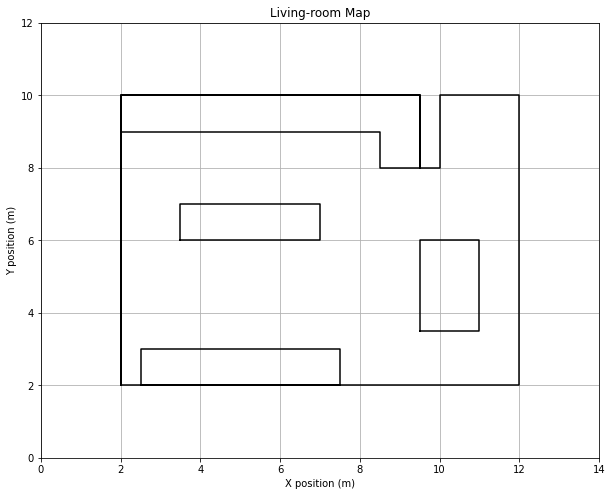

In [4]:
plot_virtual_map(virtual_map);

### The 2D laser scanner

Okay, we have defined the environment, but to observe it we need some kind of sensor. In this case we are going to work with a 2D laser simulator. The following image illustrates the appearance of this kind of sensors.

<figure style="text-align:center">
    <img src="images/sick_and_hokuyo_laser_scanners.png" width="600px" alt="">
    <figcaption>Top row, 2D laser scanners from <a href="https://www.sick.com/es/es/catalog/productos/safety/escaner-laser-de-seguridad/c/g569359" href="_blank">SICK</a>. Bottom row, left, 2D laser scanners from <a href="https://www.hokuyo-aut.jp/search/?cate01=1&cate02=1&cate03=" target="_blank">Hokuyo</a>, right, illustration of the field of view of some models of this brand.</figcaption>
</figure>


Concretely, the simulator is provided to you in the `Laser2D` class. The laser has a number of configuration parameters (properties) that can be set when creating an instance of it: 

- `FOV` -- Sensor field of view (radians)
- `resolution` -- Sensor resolution (radians)
- `max_distance` -- Max operating distance of the sensor (meters)
- `noise_cov` -- covariance matrix characterizing sensor noise
- `pose` -- sensor pose (column vector with x and y positions, and orientation theta)

To keep it simple, we consider that the laser pose is the same of the robot one, that is, the laser is placed at the center of the robot and with the same orientation. 

The following code:

- Initializes the robot pose and creates an instance of the `Laser2D` class. 
- Then, it takes an observation of the environment with the `take_observation()` method and, 
- to illustrate its operation, plots the resulting measurements with `draw_observation()`. 

Although not used in this example, there is also another interesting method, `set_pose`, that permits you to change the sensor pose according to the robot one. You can check the `Laser2D`code [here](./laser/laser2D.py).

**Execute the cell** and pay special attention to the shape and contents of the observation `z`. *Hint: `z` is composed of a number of measurements, each representing the angle of an emitted laser beam and the distance to the closest object that the beam encounters.*

In [5]:
# Set robot pose
robot_pose = np.vstack([5, 4, np.pi/4]) # [x,y,theta]

# Prepare the laser
FOV = 180 * np.pi/180     # radians
resolution = np.pi/180    #radians
max_distance = 10         # meters
noise_cov = np.array([[0.005, 0],[0, 0.0002]]) # covariance matrix
laser_pose = robot_pose   # [x,y,theta]

# Set a seed for random numbers
np.random.seed(42)

# Take and draw an observation!
laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
z = laser.take_observation(virtual_map)

print('z shape',z.shape)
print('z:',z)

z shape (2, 181)
z: [[ 1.44933656  1.48535504  1.44972204  1.60614376  1.49105623  1.52295525
   1.60612505  1.50229914  1.59002217  1.63709462  1.84708381  1.79306662
   1.79758479  1.80569238  1.89913246  1.95745292  2.06171094  2.18821718
   2.21745815  2.1872551   2.41841906  2.45041577  2.45475737  2.63689508
   2.70215997  5.870525    6.09524136  6.54503863  6.7812656   7.27933442
   7.21305053  7.13606571  7.24158301  7.15129228  7.15658839  7.13354081
   7.0847226   6.88354905  7.05872394  4.53127572  4.50165612  4.61549143
   4.44900643  4.56747165  4.46322577  4.50686442  4.45104283  4.47501672
   4.52711442  4.51135012  4.41710744  4.50055368  4.52238959  4.67759756
   4.57430463  4.43374214  4.58848405  4.5869307   4.61591399  4.71857111
   4.71467722  4.78054     4.74710997  4.66153851  4.76633948  4.67915151
   4.74503626  4.78839323  4.83323733  4.97471103  7.73972928  7.67454735
   7.87466015  7.84052473  8.04038532  8.10061629  8.11834877  8.27497218
   8.47847323  8.3

Now **visualize the virtual map and the observation** $z$ taken:

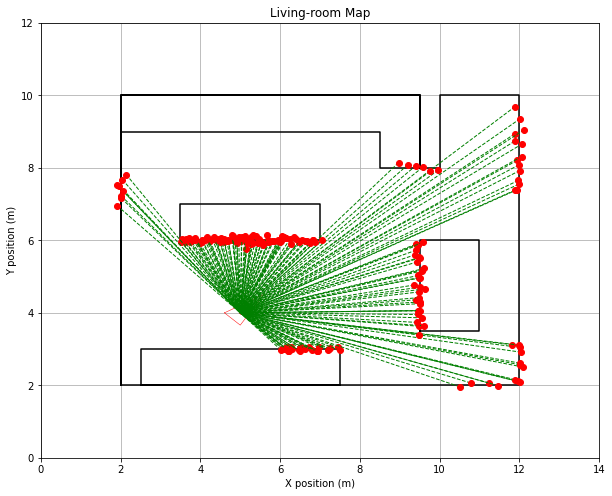

In [6]:
# Plot the map
plot_virtual_map(virtual_map, robot_pose, laser=laser, z=z);

## 6.3.3 Building a map!

Once presented the robot workspace and the 2D laser scanner the robot is equipped with, it is time to implement the occupancy grid mapping pipeline, which is as follows:

<div class="alert alert-block alert-info"> 
    
  1. Initialize the grid map, log odds, and probabilities <b><i>(Assignment 1)</i></b>. 
  2. For each new observation $z_t$: <br>
    - Do ray tracing to check which cells have been visited by each beam in the observation <b><i>(Assignments 2 and 3)</i></b>.  <br>
    - Update cells' log odds of visited cells using beams and the inverse sensor model <b><i>(Assignments 4 and 5)</i></b>.
  3. Once the robot stops collecting observations, compute final probabilities and retrieve the final map by applying an occupancy threshold <b><i>(Assignment 6)</i></b>.
</div>

### **<span style="color:green"><b><i>ASSIGNMENT 1: Initializing the occupancy grid map</i></b></span>** 

The occupancy grid map itself has two properties:
- Size (width and height, in meters)
- Resolution (in meters): Size of the size of each cell in the map.

This way, for example, if we model an environment of 10 by 10 meters with a grid resolution of 0.1 (cell side 0.1 meters), the resulting occupancy map will have a size of 100 by 100 cells. This map is stored in the `map` attribute of the `OccupancyGridMap` class (see below), and is computed in the last step of the building process.

Recall that in order to obtain this map, we first have to combine all the observations coming from the sensor ($z_{1:t}$) and the poses from which they were taken ($x_{1:t}$) in order to retrieve the probability of each cell $m_k = m_{i,j}$ being occupied by an obstacle, that is $P(m_k| z_{1:t},x_{1:t})$, which will be stored in the `probabilities` attribute. This is done more efficiently working with log odds, as we will see later, so we will also keep the log odd of each cell in the `log_odds` attribute. 

**You are tasked to:**

- Initialize the instance atribute `map` as a numpy array of ones with the right number of rows and columns as defined by the `width`, `height` and `resolution` parameters. 
- Initialize the `log_odds` attribute as a numpy array of zeros with the same size. They must be zeros since initially each cell has the same prior probability of being occupied than free, and that value represents 50% probability (we will see later on how log odds are converted into probabilities).
- Initialize the instance atribute `probabilities` as a numpy array with values $0.5$ and the same size as the previous ones.

In [7]:
class OccupancyGridMap:
    
    def __init__(self, width, height, resolution):
        """Class constructor

        Parameters:
        width (int): Map width (in meters).
        height (int): Map height (in meters).
        resolution (float): Map resolution (in meters). For example if resolution=0.1 
            this means that the side of each cell will be 10 centimiters.
        
       """
        self.width = width
        self.height = height
        self.resolution = resolution
        
        # Grid map initialization as a numpy array (notice that the height defines the 
        # number of rows, and the width the number of columns)
        
        rows = int(height / resolution)
        cols = int(width / resolution)
        
        self.map = np.ones((rows, cols))
        
        # Log odds initialization (start with zero log-odds)
        self.log_odds = np.zeros((rows, cols))

        # Probabilities initialization (start with 0.5)
        self.probabilities = np.full((rows, cols), 0.5)
        

Cool! We're now ready to create an instance of this occupancy grid map. Create a map with these properties:

- Width = 14m.
- Height = 12m.
- Resolution = 0.1m.



In [8]:
# Map configuration
map_width = 14
map_height = 12
resolution = 0.1

grid_map = OccupancyGridMap(map_width, map_height, resolution)

print('grid_map.map shape:', grid_map.map.shape)
print('grid_map.map content:\n', grid_map.map)
print('grid_map.log_odds content:\n', grid_map.log_odds)
print('grid_map.probabilities content:\n', grid_map.probabilities)

grid_map.map shape: (120, 140)
grid_map.map content:
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
grid_map.log_odds content:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
grid_map.probabilities content:
 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


<span style="color:blue">Expected output:</span>

```
grid_map.map shape: (120, 140)
grid_map.map content:
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
grid_map.log_odds content:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
grid_map.probabilities content:
 [[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
```

## Processing a new observation

To build a map, while the robot is moving around, new observations are taken. For each new observation, we've to update the region of the map observed in it. In other words, given a measurement $z_t$, we have to process the sensor beams $z_t^i \,, i\in[0,\dots,N\_beams-1]$ in the following way.

- a. Do ray tracing to check which cells have been visited by each beam in the observation.
- b. Update cells' log odds of visited cells using beams and the inverse sensor model.

### a. Ray tracing

Ray tracing enables us to retrieve the cells the beam has visited until it hits an obstacle, to which we add some cells behind the obstacle. For doing that, we need:
- The robot position.
- The beam endpoint in world coordinates.

### **<span style="color:green"><b><i>ASSIGNMENT 2: Retrieving endpoints</i></b></span>** 

**Your task** is to complete the following `beams_endpoints()` method to compute the beams' endpoints in world coordinates for a given robot position $x_t=[x_t,y_t,\theta_t]$ and an observation $z_t$. Concretely:

- Calculate the angle $ \theta^i = \theta_t + \phi^i $, where $ \phi^i $ is the angle of the $ i $-th laser beam relative to the robot's orientation at time instant $t$.

- Compute the endpoint $ (x_{\text{end}}, y_{\text{end}}) $:

    $
    x_{\text{end}} = x_t + (\rho_i + \Delta \rho )\cos(\theta_i),
    $

    $
    y_{\text{end}} = y_t + (\rho_i + \Delta \rho )\sin(\theta_i),
    $


    where $ \rho_i $ is the range measurement, and $\Delta \rho$ is an increment added to that range (`d_after_obstacle` in the code) to also update cells behind the obstacles up to that distance.

Notice that in the codeit is checked if the obtained endpoints lay within the map limits `x_min`, `x_max`,`y_min`,`y_max`. If not, `\Delta \rho` is reduced and the new endpoint is computed. This is repeteted until a valid endpoint is obtained.

In [9]:
  
def beams_endpoints(robot_pose, z, grid_map, max_attempts=10, d_after_obstacle=1):
    """
    Computes the endpoints of sensor beams in the world frame after extending beyond an obstacle,
    adjusting endpoints that fall outside the grid_map boundaries by reducing d_after_obstacle.

    Parameters:
    - robot_pose: The position and orientation of the robot [x, y, theta]^T.
    - z: Array of observations from the sensor (each element contains distance and angle).
    - grid_map: The map containing width and height attributes that define boundaries.
    - max_attempts: Maximum number of attempts to adjust each endpoint.
    - d_after_obstacle: Initial extension distance in meters.

    Returns:
    - np.array: An array of adjusted endpoints in the world frame, with shape (2, n) for n beams.
    """
    theta_robot = robot_pose.flatten()[2]
    x_robot, y_robot = robot_pose.flatten()[0], robot_pose.flatten()[1]
    
    # Map boundaries
    x_min, x_max = 0, grid_map.width - 1*grid_map.resolution
    y_min, y_max = 0, grid_map.height - 1*grid_map.resolution
    
    endpoints = []

    # Iterate over each beam in z
    for beam_distance, beam_angle in zip(z[0], z[1]):
        theta_i = theta_robot + beam_angle
        adjusted_d = d_after_obstacle  # Start with the initial d_after_obstacle for each beam

        for _ in range(max_attempts+1):
            # Calculate endpoint with the current adjusted_d
            x = x_robot + (beam_distance + adjusted_d) * np.cos(theta_i)
            y = y_robot + (beam_distance + adjusted_d) * np.sin(theta_i)

            # Check if the endpoint is within map boundaries
            if x_min <= x <= x_max and y_min <= y <= y_max:
                endpoints.append([x, y])
                break  # Found a valid endpoint, so exit the adjustment loop

            # Reduce d_after_obstacle if out of bounds
            adjusted_d -= d_after_obstacle/max_attempts 

        else: # Is executed only if the for is completed without a break (Corner case)
            # If all attempts fail, use the robot's position as a fallback endpoint
            endpoints.append([x_robot, y_robot])

    return np.array(endpoints).T  # Return in shape (2, n)
    

**Validate your implementation** with the following code:

toy_z_endpoints.shape: (2, 10)
toy_z_endpoints:
 [[ 6.65183045  7.98860875 10.53969663 10.30679675 12.84765325  7.02309812
   5.70194306  4.64678044  3.60002513  1.13445565]
 [ 2.32189001  2.56894814  3.46175212  5.3561462   9.38819416  6.85306582
   6.98728656  6.91357383  6.95675501  7.63899697]]


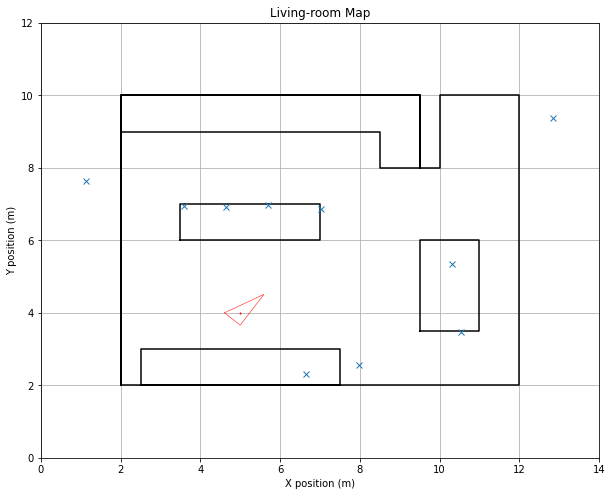

In [10]:
toy_robot_pose = np.vstack([5, 4, np.pi/4]) # [x,y,theta]
toy_z = np.array([
    [1.35469679, 2.31356178, 4.56578382, 4.47733733, 8.51936436, 2.4975578,
     2.06864873, 1.93490656, 2.27144155, 4.30892947],
    [-1.57868806, -1.23197124, -0.88225611, -0.53520384, -0.18372261, 0.16859342,
     0.55460818, 0.90604182, 1.22760849, 1.6009752]
    ])

toy_z_endpoints = beams_endpoints(toy_robot_pose,
                                  toy_z, 
                                  grid_map,
                                  d_after_obstacle=1)  

print('toy_z_endpoints.shape:',toy_z_endpoints.shape)
print('toy_z_endpoints:\n',toy_z_endpoints)

plot_virtual_map(virtual_map, toy_robot_pose, z_world=toy_z_endpoints);

<span style="color:blue">Expected output:</span>

```
toy_z_endpoints.shape: (2, 10)
toy_z_endpoints:
 [[ 6.65183045  7.98860875 10.53969663 10.30679675 12.84765325  7.02309812
   5.70194306  4.64678044  3.60002513  1.13445565]
 [ 2.32189001  2.56894814  3.46175212  5.3561462   9.38819416  6.85306582
   6.98728656  6.91357383  6.95675501  7.63899697]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 3: Doing ray tracing</i></b></span>** 

Once the starting (robot location) and endpoints are retrieved, they form lines that traverse a number of cells in the grid. But, which are there? **Ray tracing** comes to play to answer this question! Concretely, the next code cell provides a generator called `ray_tracing()` that returns the cells (their $x$ and $y$ coordinates) traversed by the line starting in $(x0,y0)$ and ending in $(x1,y1)$. It implements the **Bresenham's Line Algorithm** to determine the grid cells that are traversed, an efficient method for drawing a straight line between two points on a grid. Developed in 1962 by Jack Bresenham, the algorithm is widely used in computer graphics and robotics for its simplicity and speed, as it relies on integer arithmetic instead of floating-point calculations.

The algorithm works by maintaining an error term that tracks the deviation from the ideal line. Depending on the slope, it primarily steps along either the $x-$ or $y-$axis, adjusting the other coordinate when the error exceeds a threshold. This results in a series of discrete points that closely follow the true line.

**Implementation note: Generator function**

A **generator** in Python is a special type of function that, instead of returning a single final value with a `return` statement, yields a sequence of values one at a time, using the `yield` keyword. This allows you to iterate over the values one by one without calculating or storing them all at once, which can be more memory-efficient and can allow for computations that continue until a certain condition is met. Interesting aspects:

- When you call a generator for first time, it doesn't immediately return a result. Instead, it returns a generator object, which you can iterate over to retrieve values one at a time. Each iteration step calls the generator function and retrieves the next yielded value.
- In a generator, `yield` pauses the function, saving its current state, and returns a value to the caller. When the generator is called again (by the next iteration, for example), it resumes from where it left off, with all its local variables and state intact.

First, take a look at the `ray_tracing()`generator:


In [11]:
def ray_tracing(x0, y0, x1, y1):
    """
    Bresenham's Line Algorithm in 2D.
    Returns a generator of coordinate tuples along the line from (x0, y0) to (x1, y1).
    """

    # Round coordinates to the nearest integers to work within a discrete grid
    x0 = int(round(x0))
    y0 = int(round(y0))
    x1 = int(round(x1))
    y1 = int(round(y1))
    
    # Calculate differences in x and y between the start and end points
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    # Initialize starting point
    x, y = x0, y0

    # Determine the step direction in each axis (positive or negative)
    sx = 1 if x1 >= x0 else -1  # Step in x direction
    sy = 1 if y1 >= y0 else -1  # Step in y direction

    # Check if the line is more horizontal or vertical by comparing dx and dy
    if dy <= dx:
        # If dx is greater, we will iterate primarily in the x direction
        # Initialize error term to half of dx
        err = dx / 2.0
        while x != x1:  # Loop until we reach the end x-coordinate
            yield x, y  # Yield the current point in the line
            err -= dy  # Update error term by subtracting dy
            if err < 0:  # If error goes negative, adjust the y-coordinate
                y += sy  # Step in y direction
                err += dx  # Update error term by adding dx
            x += sx  # Step in x direction
        yield x, y  # Yield the final point (x1, y1)
    else:
        # If dy is greater, we will iterate primarily in the y direction
        # Initialize error term to half of dy
        err = dy / 2.0
        while y != y1:  # Loop until we reach the end y-coordinate
            yield x, y  # Yield the current point in the line
            err -= dx  # Update error term by subtracting dx
            if err < 0:  # If error goes negative, adjust the x-coordinate
                x += sx  # Step in x direction
                err += dy  # Update error term by adding dy
            y += sy  # Step in y direction
        yield x, y  # Yield the final point (x1, y1)


Now, **complete the following function** `gets_cells_to_upgrade()` that, given the robot pose, the beams' endpoints, and the map resolution, returns a list with the indices of the cells to be updated. For that:

- This function first converts the robot's position and each beam endpoint from world coordinates to grid cell indices, based on the map resolution. For example, if the resolution is 0.5, and the robot pose is $[2,1,\pi/4]^T$, then it will be placed at cell $(2/0.5,1/0.5)=(4,2)$.
- It then uses Bresenham's line algorithm to trace each beam from the robot's cell to the corresponding beam endpoint cell. The cells along each traced beam path are added to a list, which is then returned as the final result.

And how the `ray_tracing()` generator works here? In the ray_tracing function, `yield` is used to output each coordinate along the line one at a time:
- When you use `list(ray_tracing(...))`, Python implicitly loops through the generator to gather each yielded value and store it in a list.
- The first iteration of the loop calls the generator, which starts executing the `ray_tracing()` function from the top.

In [12]:
def get_cells_to_update(robot_pose, z_endpoints, resolution, grid_shape):
    """
    Determines which grid cells are intersected by sensor beams based on the robot's position, 
    beam endpoints, and map resolution. Only cells within the bounds of the grid map are returned.

    Parameters:
    - robot_pose (numpy array): The robot's pose in the environment as a column vector 
      with shape (3, 1), where robot_pose[0][0] is the x-coordinate and robot_pose[1][0] 
      is the y-coordinate.
    - z_endpoints (numpy array): Array of shape (2, n), where each column represents the x and y
      coordinates of the endpoint of a sensor beam, relative to the environment.
    - resolution (float): The size of each grid cell, used to convert real-world coordinates 
      into grid cell indices.
    - grid_shape (tuple): The shape of the grid map (height, width), used to validate cell indices.

    Returns:
    - cells_to_update (list): A list of lists, where each inner list contains the indices of 
      grid cells that each beam intersects and are within the grid boundaries.
    """
    
    # Initialize an empty list to store the cells to be updated for each beam
    cells_to_update = []

    # Convert the robot's position from world coordinates to grid cell indices
    robot_cell_indices = [int(robot_pose[0, 0] / resolution), int(robot_pose[1, 0] / resolution)]

    # Iterate over each beam endpoint in z_endpoints
    for beam_endpoint in z_endpoints.T:
        # Convert the beam endpoint from world coordinates to grid cell indices
        beam_x, beam_y = beam_endpoint
        beam_endpoint_cell_indices = [int(beam_x / resolution), int(beam_y / resolution)]

        # Trace the line from the robot's cell to the beam endpoint cell, getting all cells along the path
        cells_indices = list(ray_tracing(robot_cell_indices[0], 
                                         robot_cell_indices[1], 
                                         beam_endpoint_cell_indices[0], 
                                         beam_endpoint_cell_indices[1]))

        # Filter cells that are within the bounds of the grid map
        valid_cells_indices = [
            (int(x), int(y)) for x, y in cells_indices
            if 0 <= int(x) < grid_shape[1] and 0 <= int(y) < grid_shape[0]
        ]

        # Append the list of valid cells for this beam path to the main list
        cells_to_update.append(valid_cells_indices)

    # Return the list of cells that need to be updated and are within bounds
    return cells_to_update


And **validate it** with the following testing code:

toy_cells_to_update shape: 10 x [18, 30, 56, 54, 79, 29, 30, 30, 30, 40]
toy_cells_to_update (just first two beams): [[(50, 40), (51, 39), (52, 38), (53, 37), (54, 36), (55, 35), (56, 34), (57, 33), (58, 32), (58, 31), (59, 30), (60, 29), (61, 28), (62, 27), (63, 26), (64, 25), (65, 24), (66, 23)], [(50, 40), (51, 39), (52, 39), (53, 38), (54, 38), (55, 37), (56, 37), (57, 36), (58, 36), (59, 35), (60, 35), (61, 34), (62, 34), (63, 33), (64, 33), (65, 32), (66, 32), (67, 31), (68, 31), (69, 30), (70, 30), (71, 29), (72, 29), (73, 28), (74, 28), (75, 27), (76, 27), (77, 26), (78, 26), (79, 25)]]


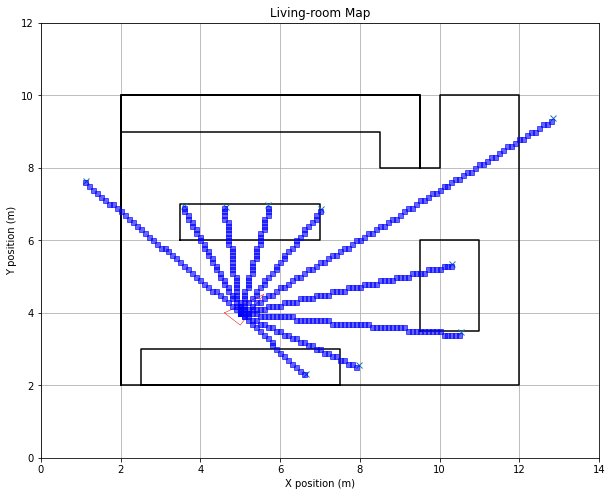

In [13]:
toy_cells_to_update = get_cells_to_update(toy_robot_pose, toy_z_endpoints, grid_map.resolution, grid_map.map.shape)

# Just to get a visual intuition of what we're doing
plot_virtual_map(virtual_map, toy_robot_pose, z_world=toy_z_endpoints, cells_to_update=toy_cells_to_update)

# Print the number of lists and the length of each sublist in cells_to_update
print("toy_cells_to_update shape:", len(toy_cells_to_update), "x", [len(sublist) for sublist in toy_cells_to_update])
print('toy_cells_to_update (just first two beams):',toy_cells_to_update[0:2])

<span style="color:blue">Expected output:</span>

```
toy_cells_to_update shape: 10 x [18, 30, 56, 54, 79, 29, 30, 30, 30, 40]
toy_cells_to_update (just first two beams): [[(50, 40), (51, 39), (52, 38), (53, 37), (54, 36), (55, 35), (56, 34), (57, 33), (58, 32), (58, 31), (59, 30), (60, 29), (61, 28), (62, 27), (63, 26), (64, 25), (65, 24), (66, 23)], [(50, 40), (51, 39), (52, 39), (53, 38), (54, 38), (55, 37), (56, 37), (57, 36), (58, 36), (59, 35), (60, 35), (61, 34), (62, 34), (63, 33), (64, 33), (65, 32), (66, 32), (67, 31), (68, 31), (69, 30), (70, 30), (71, 29), (72, 29), (73, 28), (74, 28), (75, 27), (76, 27), (77, 26), (78, 26), (79, 25)]]
```

### b. Log odds update

Cool! Each time a new observation $z_t$ comes, we're able to retrieve the observed space in terms of traversed cells. Now, to introduce the information provided by the observation, we should update the probability of cells being occupied according to it. However, to do it more effectively, we will rely on the following recursive expression for updating the **log odd values** of traversed cells:

$$\underbrace{\ln \frac{P(m_i|z_{1:t},x_{1:t})}{P(\neg m_i|z_{1:t},x_{1:t}})}_{l_t(m_i)} = 
    \underbrace{\ln \frac{P(m_i|z_t,x_t)}{P(\neg m_i|z_t,x_t)}}_{\tau_t(m_i)} + 
    \underbrace{\ln \frac{P(m_i|z_{1:t-1},x_{1_:t-1})}{P(\neg m_i|z_{1:t-1},x_{1_:t-1})}}_{l_{t-1}(m_i)} 
    \underbrace{-\ln \frac{P(m_i)}{P(\neg m_i)}}_{l_0(m_i)}$$

Expressed more conveniently as:

$$l_t(m_i)=\tau_t(m_i)+l_{t-1}(m_i)+l_0(m_i)$$

Let's know a little more the terms of this expression:

- $l_0(m_i)$: represents the **initial log-odd** of occupancy for a grid cell $m_i$ at the beginning of the map building process (before any sensor measurements are processed). It encodes the prior probability of the cell being occupied. For instance, if we start with the assumption that all cells are equally likely to be occupied or unoccupied (an occupancy probability of 0.5, so $P(m_i)=0.5$ and $P(\neg m_i)=0.5)$), then $l_0(m_i)=0$ since $ln(0.5/0.5)=0$. This is a constant value, calculated just once, at the beginning. 
- $l_{t-1}(m_i)$: is called the **prior log-odd**, the previous log-odd, serving as the recursive component of this equation.
- $\tau_t(m_i)$: represents the **sensor model in log-odds form** for the current measurement $z_t$ and robot pose $x_t$. It describes how the sensor reading affects the occupancy probability of the cell $m_i$ at current time step $t$. It represents the ratio of the probability that the cell is occupied given the current measurement, to the probability that it is not occupied given the same measurement.

This way, the only term that must be computed at each time instant $t$ is the $\tau_t(m_i)$, which is then added to the prior log-odd $l_{t-1}(m_i)$ and the initial log odd $l_0(m_i)$. Recall that this term is computed as:

$$
\tau_t(m_i) = \ln \frac{P(m_i|z_t,x_t)}{P(\neg m_i|z_t,x_t)}
$$

In other words, we need to employ the inverse sensor model to retrieve the probability $P(m_i|z_t,x_t)$. For efficiency, this must be done only for the observed cells.

#### The inverse sensor model

The **inverse sensor model** is based on the computation of the following function, representing a Gaussian probability distribution:

$$
f(d) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2} \frac{(d - z_t)^2}{\sigma^2}}
$$

where:
- $z_t$ is the observed distance to an object detected by the sensor.
- $\sigma$ is the standard deviation, as provided by the laser manufacturer or obtained experimentally.
- $d=d(x_t,m_i)$ is the distance from the laser position at instant $t$ (here, the same as the laser position $x_t$) to the cell $m_i$.

Concretely, this function is used to define the occupancy probability for cells at varying distances $d$ along the beam path as:

$$
P(m_i | z_t, x_t) = 
\begin{cases} 
l_{\text{th}} & \text{if } d < z_t \text{ and } f(d) < l_{\text{th}} \\ 
0.5 & \text{if } d > z_t \text{ and } f(d) < 0.5 \\ 
f(d) & \text{Otherwise} 
\end{cases}
$$

The following image visually illustrates the meaning of this definition, as well as how it is used to retrieve log odds (to be explained in the next assignment).

<figure style="text-align:center">
  <img src="images/inverse_sensor_model.jpg" alt="">
</figure>

Notice that this approach avoids setting probabilities to exactly 0 or 1 to account for uncertainties like sensor noise and improve numerical stability.

### **<span style="color:green"><b><i>ASSIGNMENT 4: Implementing the inverse sensor model</i></b></span>** 

**Your task is** to complete the following `inverse_beam_sensor_model` that, given:
- the robot pose (`robot_pose`),
- an observation (`z`), and
- a list of cells to be updated (`cells_to_update`),

returns a list of the same shape (`p_cell_occupied`) with the probabilities of those cells being occupied. Some considerations:

- Set the lower probability threshold $l_{th}$ to $0.2$.
- Set `sigma`, the sensor uncertainty, as `0.4`.
- If the value computed by `f` is larger than $0.8$, saturate it to that value.

In [41]:
def inverse_beam_sensor_model(robot_pose, z, cells_to_update, resolution):
    """
    Computes the occupancy probabilities for cells traversed by each beam 
    in a laser observation, based on an inverse sensor model. 

    Parameters:   
    - robot_pose: np.array
        The pose of the robot as a 2D array, where the first row contains 
        the x-coordinate and the second row contains the y-coordinate of 
        the robot.
    - z: np.array
        A 2D array with the observation taken.
    - cells_to_update: list of lists
        A list where each element is a list of (i, j) cell indices that 
        correspond to the cells visited by a specific beam.
     - resoultion: resolution of the grid map being built

    Returns:
    - p_cell_occupied: list of lists
        A list with the same structure as `cells_to_update`, containing 
        the computed occupancy probabilities for each cell along each beam.
    """
    
    sigma = 0.4 # Standard deviation modeling sensor uncertainty       
    l_th = 0.2  # Lower probability threshold
    
    # Define robot position in terms of cells
    x = robot_pose[0, 0]/resolution
    y = robot_pose[1, 0]/resolution
    
    # Number of beams in the observation
    n_beams = z.shape[1]

    # Initialize output list to store occupancy probabilities for each beam
    p_cell_occupied = [[] for _ in range(n_beams)]
    
    # Process each beam observation
    for beam_index in np.arange(n_beams):
        
        # The measured distance for the current beam in terms of cells
        z_i = z[0, beam_index]/resolution
        #print(f"Beam {beam_index}: Measured distance z_i = {z_i}")

        # Calculate occupancy probability for each cell traversed by the beam
        for cell in cells_to_update[beam_index]:
            
            # Compute Euclidean distance between the robot and the cell
            
            d = np.sqrt((cell[0] - x)**2 + (cell[1] - y)**2)
            #print(f"Cell {cell}: Distance d = {d}")
            
            # Compute the value for the gaussian probability distribution
            f = (np.exp(- (d - z_i)**2 / (2 * sigma**2)))/np.sqrt(2*np.pi*sigma**2) 
            #print(f"Cell {cell}: Gaussian probability f = {f}")

            # Determine final occupancy probability based on conditions
            if d < z_i and f < l_th:
                p_cell_occupied[beam_index].append(l_th)
            elif d > z_i and f < 0.5:
                p_cell_occupied[beam_index].append(0.5)
            else:
                if f > 0.8:
                    f = 0.8
                p_cell_occupied[beam_index].append(f)
            #print(f"Cell {cell}: Final probability = {p_cell_occupied[beam_index][-1]}")

                    
    return p_cell_occupied


**Check** that your implementation is right:

In [42]:
toy_p_cells_occupied = inverse_beam_sensor_model(toy_robot_pose, 
                                                toy_z, 
                                                toy_cells_to_update,
                                                grid_map.resolution)

print('toy_p_cells_occupied (just two first beams):\n',toy_p_cells_occupied[0:2])

toy_p_cells_occupied (just two first beams):
 [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]


<span style="color:blue">Expected output:</span>

```
toy_p_cells_occupied (just two first beams):
 [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 5: Updating log odds and probabilities</i></b></span>** 

And the time has come for updating the log odds! As commented, for efficiency, this is just done for the cells traversed by any beam. **Complete the following cell** to do two things:

- First, compute initial log odds $l_0$ for all the cells, taking into account that the prior probability of a cell being occupied is 0.5 ($P(m_i)=0.5$).
- Then, define the `update_log_odds()` function that given:
  - the map to be updated (`grid_map`),
  - the cells to be updated (`p_cells_occupied`),
  - the probability of said cells according to the inverse sensor model (`p_cells_occupied`),
  - and the mentioned initial log odd $l_0$,

  updates the log_odds of cells traversed by any beam.

  **Important note:** take into account that when indexing a matrix using `[row][col]`, `x` coordinates refers to columns and `y` coordinates to rows!

In [43]:
p_occupied = 0.5
p_free = 1-p_occupied
l_0 = np.log(p_occupied / p_free)

def update_log_odds(grid_map, cells_to_update, p_cells_occupied, l_0):
    """
    Updates the log-odds values of cells in the occupancy grid map based on new sensor observations.

    Parameters:
    - grid_map: object
        The occupancy grid map object that has an attribute `log_odds`, a 2D array representing
        the log-odds values of occupancy for each cell in the map.
    - cells_to_update: list of lists
        A list where each element is a list of (i, j) tuples representing the indices of cells 
        traversed by a specific beam. Each sublist corresponds to one beam in the observation.
    - p_cells_occupied: list of lists
        A list of lists containing the occupancy probabilities for each cell in each beam path.
        The structure matches `cells_to_update`, where each sublist corresponds to one beam.
    - l_0: float
        The prior log-odds value used to initialize cells. This value is added to each cell's 
        log-odds during updates to incorporate prior knowledge.

    This function updates `grid_map.log_odds` in-place, incorporating the latest observation data 
    and progressively refining the map’s understanding of which cells are likely occupied or free.
    """

    # Iterate over observation beams
    for beam_index in range(len(cells_to_update)):
        
        # Iterate over the cells traversed by this beam
        for traversed_cell, p_occupied in zip(cells_to_update[beam_index], p_cells_occupied[beam_index]):

            # Compute the sensor model log odd
            tau_t = np.log(p_occupied / (1 - p_occupied))

            # Update cell log odds!
            grid_map.log_odds[traversed_cell[1]][traversed_cell[0]] += tau_t - l_0


**Test your implementation**:

In [44]:
update_log_odds(grid_map,
                toy_cells_to_update, 
                toy_p_cells_occupied, 
                l_0)

print('log_odds (just for a portion of the map):\n',grid_map.log_odds[55:60,40:45])

log_odds (just for a portion of the map):
 [[ 0.          0.          0.         -1.38629436  0.        ]
 [ 0.          0.         -1.38629436  0.          0.        ]
 [ 0.          0.         -1.38629436  0.          0.        ]
 [ 0.         -1.38629436  0.          0.          0.        ]
 [ 0.         -1.38629436  0.          0.          0.        ]]


<span style="color:blue">Expected output **JUST AFTER THE FIRST EXECUTION!** If you execute the cell more than one time, you are simulating multiple observations from the same pose:</span>

```
log_odds (just for a portion of the map):
 [[ 0.          0.          0.         -1.38629436  0.        ]
 [ 0.          0.         -1.38629436  0.          0.        ]
 [ 0.          0.         -1.38629436  0.          0.        ]
 [ 0.         -1.38629436  0.          0.          0.        ]
 [ 0.         -1.38629436  0.          0.          0.        ]]
```

Once we have updated the log odds, we can retrieve the probability of each cell being occupied. This is done just once, when the robot has completed the environment exploration, but we will define a function to do it in each iteration just to visualize how probabilities evolve.

**You are tasked to** complete the `update_probabilities()` function that, according to log odd values (stored in `grid_map.log_odds`) updates cells' probabilities (stored in `grid_map.probabilities`) using the following expression:

$$
P(m_i | z_{1:t}, x_{1:t}) = \frac{e^{l_t(m_i)}}{1 + e^{l_t(m_i)}} = 1 - \frac{1}{1 + e^{l_t(m_i)}}
$$

In [45]:
def update_probabilities(grid_map):
    """
    Updates the occupancy probabilities in the grid map based on the current log-odds values.

    This function converts log-odds values stored in `grid_map.log_odds` to occupancy probabilities 
    and stores the result in `grid_map.probabilities`. It uses the sigmoid function to map log-odds 
    to probability values, where each cell's probability represents the likelihood of being occupied.

    Parameters:
    - grid_map: An object containing:
        - log_odds: A 2D numpy array with log-odds values for each cell in the occupancy grid.
        - probabilities: A 2D numpy array that will be updated with the computed occupancy probabilities.

    Note:
    This function modifies `grid_map.probabilities` in place.
    """
    grid_map.probabilities = 1 - 1/(1+np.exp(grid_map.log_odds))


### Putting all together

Until now we have implemented the needed building blocks to, given a new observation $z$, process it and update the log odds an probabilities of a map. Now it's time to put all together!

Before that, take a look at the following function, `plot_state()`, which shows the virtual map, the robot pose, beams' endpoints, and the map probabilities after processing an observation. It is also provided the `create_and_display_buttons()` function, that will permit you to move the robot in the environment.

In [46]:
def plot_state(robot_pose, z_world, virtual_map, grid_map, cells_to_update=None):
    """
    Plots the robot pose, map, beam endpoints, and optionally grid cells to be updated
    alongside the occupancy grid map.

    Parameters:
    - robot_pose: The position of the robot as a numpy array or list with shape (2, 1).
    - z_world: Array of beam endpoints in world coordinates.
    - virtual_map: The map to be plotted (e.g., walls or environment boundaries).
    - grid_map: Object containing occupancy probabilities for each cell in the grid.
    - cells_to_update (optional): List of lists of grid cell coordinates to update.
    - resolution: Resolution for converting cell coordinates to world coordinates (default is 1).
    """
    with output:  # Direct output to the Output widget
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot the virtual map (environment boundaries or walls) in the first subplot
        ax1.plot(virtual_map[0, :], virtual_map[1, :], 'k-')
        
        # Set grid and axis limits
        ax1.grid()
        ax1.set_xlim(np.nanmin(virtual_map[0])-2,np.nanmax(virtual_map[0])+2) # nanmin ignores nan numbers
        ax1.set_ylim(np.nanmin(virtual_map[1])-2,np.nanmax(virtual_map[1])+2)  
        
        # Title and axis labels
        ax1.set_title('Living-room Map')
        ax1.set_xlabel('X position (m)')
        ax1.set_ylabel('Y position (m)')   
                
        # Plot the beam endpoints in world coordinates
        ax1.plot(z_world[0], z_world[1], 'x')
        
        # If cells_to_update is provided, plot the grid cells to be updated
        if cells_to_update is not None:
            for cell_path in cells_to_update:
                ax1.plot([cell[0] * grid_map.resolution for cell in cell_path], 
                         [cell[1] * grid_map.resolution for cell in cell_path], 
                         's', markersize=5, color='blue', alpha=0.2)

            
        # Draw robot (the usual DrawRobot function doesn't work because of the subplots) 
        ax1.plot(robot_pose[0, 0], robot_pose[1, 0], 'o', color='red', markersize=10, alpha=0.6)
        orientation_length = 0.5  # Length of the orientation line
        x_start, y_start = robot_pose[0, 0], robot_pose[1, 0]
        x_end = x_start + orientation_length * np.cos(robot_pose[2, 0])
        y_end = y_start + orientation_length * np.sin(robot_pose[2, 0])
        ax1.plot([x_start, x_end], [y_start, y_end], color='red', linewidth=2, alpha=0.7)

        # Plot the occupancy grid map with probabilities in the second subplot
        cax = ax2.imshow(grid_map.probabilities, cmap='gray_r', origin='lower', vmin=0, vmax=1)
        ax2.set_title('Occupancy Grid Map')
        ax2.set_xlabel('X (cells)')
        ax2.set_ylabel('Y (cells)')
        fig.colorbar(cax, ax=ax2, label='Occupancy Probability')

        plt.tight_layout()
        plt.show()
        plt.close(fig)  # Ensure the figure is closed after display to avoid lingering

def create_and_display_buttons():

    translation_step = 0.5
    rotation_step = np.pi/4
    
    def on_button_up_click(b):
        move_robot(dx=translation_step)
    
    def on_button_down_click(b):
        move_robot(dx=-translation_step)
    
    def on_button_left_click(b):
        None
    
    def on_button_right_click(b):
        None
    
    def on_button_rotate_left_click(b):
        move_robot(dtheta=rotation_step)
    
    def on_button_rotate_right_click(b):
        move_robot(dtheta=-rotation_step)
    
    button_up = widgets.Button(description="↑")
    button_down = widgets.Button(description="↓")
    button_left = widgets.Button(description=" ")
    button_right = widgets.Button(description=" ")
    button_rotate_left = widgets.Button(description="↺")
    button_rotate_right = widgets.Button(description="↻")
    
    button_up.on_click(on_button_up_click)
    button_down.on_click(on_button_down_click)
    button_left.on_click(on_button_left_click)
    button_right.on_click(on_button_right_click)
    button_rotate_left.on_click(on_button_rotate_left_click)
    button_rotate_right.on_click(on_button_rotate_right_click)
    
    control_box = widgets.HBox([button_rotate_left, button_up, button_rotate_right])
    control_box2 = widgets.HBox([button_left, button_down, button_right])
    display(control_box, control_box2)

### **<span style="color:green"><b><i>ASSIGNMENT 6: Combining All Parts</i></b></span>** 

It's the moment to put all our machinery to work. For that, **you have to complete** the `process_new_observation()` function that, given a `grid_map`, a `robot_pose`, and an observation `z`, process said observation and update log odds and probabilities.

There is also a second function to be completed, called `move_robot()`, which receives as argument a pose increment, and moves the robot by composing its pose with said increment using our loved `tcomp()` function. After that, it sets the laser pose accordingly, takes a new measurement, and calls `process_new_observation()`. This is the function that will be called each time a button to move the robot is pressed.

In [47]:
def process_new_observation(grid_map, robot_pose, z):
    """
    Processes a new sensor observation to update the occupancy grid map.
    
    Parameters:
    - grid_map: An object representing the occupancy grid map. It should contain:
        - map.shape: Shape of the map grid to check boundary limits.
        - resolution: Resolution of each cell in the grid map.
        - log_odds: 2D numpy array of log-odds values for each cell.
    - robot_pose: The robot's current pose, represented as a numpy array of shape (3, 1)
      containing [x, y, theta].
    - z: Sensor observations,  representing distances and angles of detected obstacles.

    """
    z_endpoints = beams_endpoints(robot_pose, z, grid_map)  
    cells_to_update = get_cells_to_update(robot_pose, z_endpoints, grid_map.resolution, grid_map.map.shape)    
    p_cells_occupied = inverse_beam_sensor_model(robot_pose, z, cells_to_update, grid_map.resolution)
    update_log_odds(grid_map, cells_to_update, p_cells_occupied, l_0)
    update_probabilities(grid_map)    

    # Display control buttons and plot the updated map and robot state
    create_and_display_buttons()
    plot_state(robot_pose, z_endpoints, virtual_map, grid_map, cells_to_update)


def move_robot(dx=0, dy=0, dtheta=0):
    """
    Moves the robot by applying a specified translation and rotation, and processes the new observation.

    Parameters:
    - dx: Displacement along the x-axis.
    - dy: Displacement along the y-axis.
    - dtheta: Rotation angle to be applied (in radians).
    """
    global robot_pose
    u = np.vstack([dx, dy, dtheta])  # Movement vector

    # Update the robot pose with the new movement
    robot_pose = tcomp(robot_pose, u)
    
    # Update the laser's pose and take a new observation
    laser.set_pose(robot_pose)
    z = laser.take_observation(virtual_map)
    
    # Process the new observation to update the map
    process_new_observation(grid_map, robot_pose, z)


Okay, it's time to stop working and have a bit of fun. **Execute the code below**, move the robot, and **build a map!** 

You should obtain something like this:

<figure>
  <img src="images/final_occupancy_grid_map_probabilities.jpg" alt="">
</figure>

In [49]:
# Initialize robot pose and robot map
robot_pose = np.vstack([5, 4, np.pi / 4])  # [x, y, theta]
grid_map = OccupancyGridMap(map_width, map_height, resolution)

# Define an Output widget
output = widgets.Output()

#create_and_display_buttons()
display(output)  # Display the output widget for plotting

# Process first observation
process_new_observation(grid_map, robot_pose, z)

Output()

Cool! We now have the final log odds and probability values! This is just one remaining thing to do to build the occupancy grid map... to decide if a cell is occupied or free according to their probabilities. For doing that we are going to use this simple rule:


$$
m_i = 
\begin{cases} 
0 & \text{if } P(m_i | z_{1:t}, x_{1:t}) > u_{\text{th}} \\ 
1 & \text{if } P(m_i | z_{1:t}, x_{1:t}) < l_{\text{th}} \\ 
0.5 & \text{Otherwise} 
\end{cases}
$$


where $u_{\text{th}}$ and $l_{\text{th}}$ are thresholds to consider if a cell is occupied or free according to its probability. 

The next cell do that, so **execute it** and enjoy with your result!

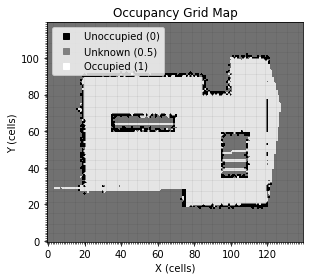

In [51]:
# Define thresholds
lower_threshold = 0.3  # Probability below this will be set to 0
upper_threshold = 0.7 # Probability above this will be set to 1

# Update the map based on thresholds
grid_map.map = np.full_like(grid_map.probabilities, 0.5)
grid_map.map[grid_map.probabilities < lower_threshold] = 1
grid_map.map[grid_map.probabilities > upper_threshold] = 0

# Assume grid_map.map is already defined with values 0, 0.5, and 1
# Define a simple color map for the three values
cmap = plt.cm.get_cmap('gray', 3)  # 'gray' with 3 discrete colors for 0, 0.5, and 1

# Plot the occupancy grid map
plt.imshow(grid_map.map, cmap=cmap, origin='lower', vmin=0, vmax=1)
plt.title('Occupancy Grid Map')
plt.xlabel('X (cells)')
plt.ylabel('Y (cells)')

# Add grid overlay
plt.gca().set_xticks(np.arange(-0.5, grid_map.map.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, grid_map.map.shape[0], 1), minor=True)
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=0.1)

# Add a simple legend to represent the three values
labels = ['Unoccupied (0)', 'Unknown (0.5)', 'Occupied (1)']
colors = [cmap(i) for i in range(3)]
for color, label in zip(colors, labels):
    plt.plot([], [], 's', color=color, label=label)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<span style="color:blue">Expected output</span>

<figure>
  <img src="images/final_occupancy_grid_map.jpg" alt="">
</figure>

## Conclusion

In this notebook, we covered the fundamental steps of building an Occupancy Grid Map (OGM), a popular technique for robotic navigation and environment mapping. Here’s a summary of what we learned:

- **Concept of Occupancy Grid Maps:** We explored how OGMs divide the environment into a grid, where each cell holds a probability of being occupied or free, enabling robots to model their surroundings with uncertainty.
- **Sensor Integration and Ray Tracing:** We used a 2D laser scanner to gather distance measurements. Ray tracing was used to identify which cells each laser beam intersects, providing information for occupancy updates.

- **Probabilistic Updates with Log-Odds:** To handle noisy sensor data and maintain consistency, we applied log-odds to update the occupancy probabilities. This allowed for incremental updates as new observations were gathered.

- **Complete Pipeline Implementation:** Combining all elements, we created a pipeline that:

  - Processes sensor observations,
  - Updates the grid map based on probabilities,
  - Visualizes the map building state.

With this notebook we have got a deeper understanding of how robots can map their surroundings and make decisions based on probabilistic data.

## <span style="color:green">OPTIONAL</span>

<span style="color:green">
<p>There are many aspects of the implementation that can be improved to do it more realistic. Some ideas:</p>
<ul>
    <li>Include time measurements in the code to detect bottlenecks and do it more efficient.</li>
    <li>Consider that the localization is not given, so you have to compute it when the robot moves. You can use, for example, ICP.</li>
    <li>There are different alternatives to do ray tracing, implement a different one. Some options appear in this paper: <a href="https://www.sciencedirect.com/science/article/pii/S0921889023000027" target="_blank">Object-wise comparison of LiDAR occupancy grid scan rendering methods</a>
    <li>Implement moving obstacles (people, pets, etc.).</li>
    <li>Laser related:
    <ul>
        <li>Test the efect of different real lasers (surf the internet to find them, e.g. Hokuyo, Sick) in the resulting map (different FOV, max range, resolution, error, etc.).</li>
        <li>Implement additional sources of uncertainty in the laser measurements: random and max range.</li>
        <li>Implement different surfaces in the map, so the sensor performance may vary (e.g., appearing large errors). For example, black surfaces absorb more infrarred rays, difficulting sensor operation.</li>
        <li>Change the virtual map definition to an arbitrary input image, and implement a new laser simulator able to work with this new representation (e.g. ray tracing). </li>
    </ul>
    </li>    
</ul>
</span>

<span style="color:green">***END OF OPTIONAL PART***</span>